## Serial Dilution
Get familiar with science-jubilee functionality using this 2D serial dilution example notebook! We'll mix colors using a syringe tool and measure some optical properties of the colors we mix. 

In [1]:
# Import the tools we'll need!
from science_jubilee.Machine import Machine
from science_jubilee.tools.Syringe import Syringe
from science_jubilee.tools.AS7341 import AS7341
from science_jubilee.decks import Deck
import json

In [2]:
# Connect to the machine
m = Machine(address='localhost')

### 1. Set up our tools
We'll use a syringe tool to move liquid and a lab automation deck to hold labware 

In [3]:
# The syringe is tool 0 on the machine
syringe = Syringe(index = 0, name = 'syringe1', config = '10cc_syringe')
spec = AS7341(index = 2, name = "AS7341 spectral sensor", config = "AS7341")
m.load_tool(syringe)
m.load_tool(spec)

# We use a lab automation deck to hold labware 
deck = m.load_deck('lab_automation_deck')

In [ ]:
# Pick up the syringe!
m.pickup_tool(syringe)

# Drop the bed down so we have room to load our labware
m.move_to(z=150)

In [4]:
# pick up the spectral sensor tool!
m.pickup_tool(spec)

# sensors are controlled by and communicated via nodes! and nodes need to be connected to the pi first ->
spec.connect_seeed() 
# we only have one node now so there is no need for an index 
# but we will probably get to multiple sensors later

# blink the connected node! the argument in the blink function is the duration of blinking in second
spec.blink("1")

In [ ]:
# yay it blinks! now let's take a measurement
# the argument is the current of the LEDs surrounding the spectral sensor
# range: 0 - 40 mA
spec.measure_spectrum(3)

### 2. Load our labware!
We'll use petri dishes to hold our liquids, and a 24-well plate to mix colors. Now, you should add:
- a petri dish filled with water into slot 0
- a 24 well plate into slot 1
- a petri dish filled with colored water into slot 1

Once you've inserted these into the machine, run the following cells.

In [5]:
# We put our liquid reservoirs into slot 0 and 2 of the machine
water = m.load_labware("generic_petri_dish_100ml", 0)
color = m.load_labware("generic_petri_dish_100ml", 2)

# There's only 1 "well" in a petri dish!
water = water["A1"]
color = color["A1"]

# We put our 24 well plate into slot 1 of the machine
samples = m.load_labware("greiner_24_wellplate_3300ul", 1)

In [6]:
# Pozzo group changed the Labware class props to not refer to the Wells?
# I'm gathering them manually here and will ask if I can change back
all_wells = [samples.wells[id] for id in samples.wells]

rows = {}
columns = {}
for row in samples.row_data:
    rows[row] = []
    for well_id in samples.row_data[row]:
        rows[row].append(well_id)

for column in samples.column_data:
    columns[column] = []
    for well_id in samples.column_data[column]:
        columns[column].append(well_id)

### 3. Set up the sample plate
The following cells will:
- move water into all wells of the 24 well plate
- move colored water into the first column



In [ ]:
# Put decreasing amount of water into first column
fill_volume = 2
step_size = 0.5
for well in columns[1]:
    syringe.transfer(vol = fill_volume, source = water, destination = well)
    fill_volume -= step_size

In [ ]:
# Add water to all other wells
for column in range(2, len(samples.column_data)+1):
    syringe.transfer(vol = 1.5, source = water, destination = columns[column])

In [ ]:
# Add increasing amount of colored water to the first column
fill_volume = 0.5
for well in columns[1]:
    syringe.transfer(
        vol = fill_volume,
        source = color,
        destination = well,
        mix_after=(1,2)
    )
    fill_volume += step_size

if neededif needed### Run Serial Dilution!
The following cell will transfer and mix samples down each column of the well plate

In [ ]:
for row in rows:
    for column in range(1, len(samples.column_data)):
        syringe.transfer(
            vol = 1.5,
            source = samples.wells[f"{row}{column}"],
            destination = samples.wells[f"{row}{column+1}"],
            mix_after = (1, 2)
        )
        # Can add code to switch tools and measure something here!

### Measure Redness!

In [ ]:
# Pickup tool!
m.pickup_tool(spec)

In [7]:
m.move_to(z=-15);

In [8]:
measurements = []
for row in rows:
    for column in range(1, len(samples.column_data)):
        well = samples.wells[f"{row}{column}"]
        m.move_to(x=well.x, y=well.y);
        measure = {
            'well id' : f"{row}{column}",
            'spectral measurements' : spec.measure_spectrum(3)
        }
        measurements.append(measure)
        print(measure)

# write to json
wellplate_results = json.dumps(measurements, indent = 4)
with open('wellplate_spectral_measurements.json', 'w') as f:
    f.write(wellplate_results)

{'well id': 'A1', 'spectral measurements': "{'445': 16916, '480': 13391, '555': 32229, '590': 33343, '515': 15763, '415': 3903, '630': 33139, '680': 15727}"}
{'well id': 'A2', 'spectral measurements': "{'445': 16772, '480': 13326, '555': 31853, '590': 33546, '515': 15615, '415': 3909, '630': 33417, '680': 15789}"}
{'well id': 'A3', 'spectral measurements': "{'445': 17809, '480': 13788, '555': 33656, '590': 34959, '515': 16766, '415': 4100, '630': 33885, '680': 15958}"}
{'well id': 'A4', 'spectral measurements': "{'445': 18987, '480': 14305, '555': 35792, '590': 36107, '515': 18253, '415': 4291, '630': 34220, '680': 16070}"}
{'well id': 'A5', 'spectral measurements': "{'445': 19650, '480': 14603, '555': 37060, '590': 36563, '515': 19185, '415': 4393, '630': 34208, '680': 16085}"}
{'well id': 'B1', 'spectral measurements': "{'445': 16212, '480': 13103, '555': 31056, '590': 31842, '515': 15128, '415': 3759, '630': 32440, '680': 15531}"}
{'well id': 'B2', 'spectral measurements': "{'445': 

#### Visualize Stuff

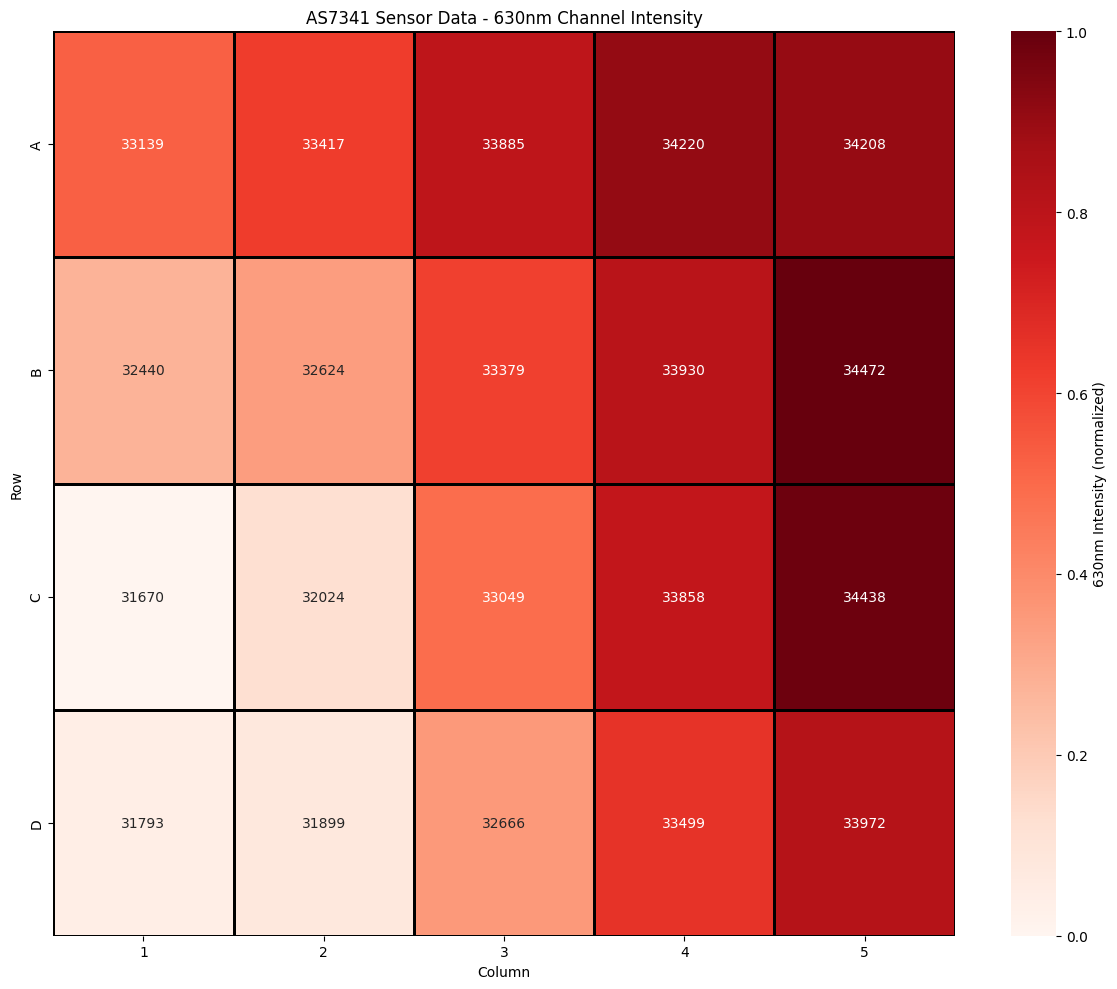

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re


# Function to parse dictionary string without using ast
def parse_dict_string(dict_str):
    # Replace single quotes with double quotes for JSON parsing
    json_str = dict_str.replace("'", "\"")
    try:
        # Try parsing as JSON
        return json.loads(json_str)
    except json.JSONDecodeError:
        # Fallback method: manual parsing using regex
        result = {}
        # Find all key-value pairs
        pattern = r"'([^']+)':\s*(\d+)"
        matches = re.findall(pattern, dict_str)
        for key, value in matches:
            result[key] = int(value)
        return result

# Extract row and column information and organize data
data_by_position = {}
rows = set()
cols = set()

for item in measurements:
    well_id = item['well id']
    row = well_id[0]  # e.g., 'A' from 'A1'
    col = int(well_id[1:])  # e.g., 1 from 'A1'
    
    # Parse the spectral measurements
    spectral_data = parse_dict_string(item['spectral measurements'])
    
    # Store by position
    data_by_position[well_id] = spectral_data
    
    # Track unique rows and columns
    rows.add(row)
    cols.add(col)

# Sort rows and columns
rows = sorted(list(rows))
cols = sorted(list(cols))

# Create a grid for the '630' value (closest to the requested '620')
grid_data = np.zeros((len(rows), len(cols)))

# Fill the grid with '630' values
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        well_id = f"{row}{col}"
        if well_id in data_by_position:
            # Use '630' value 
            grid_data[i, j] = data_by_position[well_id].get('630', 0)

# Normalize the data to range 0-1 for color mapping
max_value = np.max(grid_data)
min_value = np.min(grid_data[grid_data > 0])  # Ignore zeros for better contrast
normalized_grid = (grid_data - min_value) / (max_value - min_value)
normalized_grid[grid_data == 0] = 0  # Keep zeros as zeros

# Create the heatmap visualization
plt.figure(figsize=(12, 10))
ax = sns.heatmap(normalized_grid, 
                annot=grid_data.astype(int),  # Show the original values as annotations
                fmt="d",                     # Format as integers
                cmap="Reds",                 # Red colormap
                cbar_kws={'label': '630nm Intensity (normalized)'},
                linewidths=1,
                linecolor='black')

# Set custom tick labels for rows and columns
plt.yticks(np.arange(len(rows)) + 0.5, rows)
plt.xticks(np.arange(len(cols)) + 0.5, cols)

plt.title('AS7341 Sensor Data - 630nm Channel Intensity')
plt.xlabel('Column')
plt.ylabel('Row')

plt.tight_layout()
plt.show()


In [10]:
# Misc.
# Dropoff tool!
m.park_tool()

In [ ]:
# water transfer to all wells
# syringe.transfer(vol = 1, source = water, destination = all_wells)

# test single transfer
# syringe.transfer(vol = 1, source = water, destination = sample_well)